## Prediction with Movement dependency


Notebook to train and test prediction models that use movement dependent and/or movement independent data / features

In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from itertools import compress, product
import pandas as pd
import numpy as np
import sklearn as sk
from scipy import signal, stats

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [3]:
projectpath = get_project_path_in_notebook()


Import own functions

In [4]:
os.chdir(os.path.join(projectpath, 'code'))

# own utility functions
import utils.utils_fileManagement as utilsFiles

# own data exploration functions
import lfpecog_features.feats_read_proc_data as read_data
import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.ft_processing_helpers as ftProc
import lfpecog_analysis.import_ephys_results as importResults
import lfpecog_analysis.stats_fts_lid_corrs as ftLidCorr
import lfpecog_analysis.psd_lid_stats as lidStats
import lfpecog_analysis.load_SSD_features as load_ssdFts
import lfpecog_analysis.ft_processing_helpers as ftProc
import lfpecog_features.feats_helper_funcs as ftHelp
from lfpecog_features.get_ssd_data import get_subject_SSDs

import lfpecog_predict.prepare_predict_arrays as predArrays
import lfpecog_features.extract_ssd_features as ssdFeats

from lfpecog_plotting.plotHelpers import get_colors
import lfpecog_plotting.plotHelpers as pltHelp
import lfpecog_plotting.plot_FreqCorr as plotFtCorrs
import lfpecog_plotting.plot_SSD_feat_descriptives as plot_ssd_descr

check versions

In [5]:
from  matplotlib import __version__ as plt_version

# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('matplotlib', plt_version)
# Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
# pandas 1.4.4
# numpy 1.23.3
# matplotlib 3.5.3

Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
matplotlib 3.5.3


### Import data

imports SSD-band-envelops with parallel CDRS, timestamps, task, movement-coding

In [6]:
# SET VERSIONS

FT_VERSION='v6'
SETTINGS = utilsFiles.load_ft_ext_cfg(FT_VERSION=FT_VERSION)

SUBS = utilsFiles.get_avail_ssd_subs(
    DATA_VERSION=SETTINGS["DATA_VERSION"],
    FT_VERSION=FT_VERSION,
)

In [7]:
importlib.reload(predArrays)

# get move-selected env arrays
# contains: freq-bands, CDRS, timestamps, tasks, mov-coding
DATA, env_fbands = {}, {}

for sub in SUBS:
    DATA[sub], env_fbands[sub] = predArrays.get_move_selected_env_arrays(
        sub=sub, LOAD_SAVE=True
    )

- LOADED ecog_right: sub017_ecog_right_movEnvArray_gamma8590.npy
- LOADED lfp_left: sub017_lfp_left_movEnvArray_gamma7277.npy
- LOADED lfp_right: sub017_lfp_right_movEnvArray_gamma7580.npy
- LOADED ecog_right: sub014_ecog_right_movEnvArray_gamma8590.npy
- LOADED lfp_left: sub014_lfp_left_movEnvArray_gamma8085.npy
- LOADED lfp_right: sub014_lfp_right_movEnvArray_gamma7075.npy
- LOADED ecog_right: sub019_ecog_right_movEnvArray_gamma7580.npy
- LOADED lfp_left: sub019_lfp_left_movEnvArray_gamma8287.npy
- LOADED lfp_right: sub019_lfp_right_movEnvArray_gamma6065.npy
- LOADED ecog_right: sub020_ecog_right_movEnvArray_gamma8590.npy
- LOADED lfp_left: sub020_lfp_left_movEnvArray_gamma6065.npy
- LOADED lfp_right: sub020_lfp_right_movEnvArray_gamma6065.npy
- LOADED ecog_right: sub021_ecog_right_movEnvArray_gamma7580.npy
- LOADED lfp_left: sub021_lfp_left_movEnvArray_gamma7580.npy
- LOADED lfp_right: sub021_lfp_right_movEnvArray_gamma8085.npy
- LOADED lfp_left: sub102_lfp_left_movEnvArray_gamma828

#### Visualise ratio biomarker

In [42]:
print(DATA['107']['lfp_left'].shape)
print(env_fbands['107']['lfp_left'])

idx_sort = np.argsort(DATA['013']['lfp_left'][i_time, :])
sort_arr = DATA['013']['lfp_left'][:, idx_sort]

(12, 5010405)
{'theta': [4, 8], 'alpha': [8, 12], 'lo_beta': [12, 20], 'hi_beta': [20, 35], 'gamma1': [60, 70], 'gamma2': [70, 80], 'gamma3': [80, 90], 'gammaPeak': [75, 80]}


(6398049,)


ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 1, 6398049)

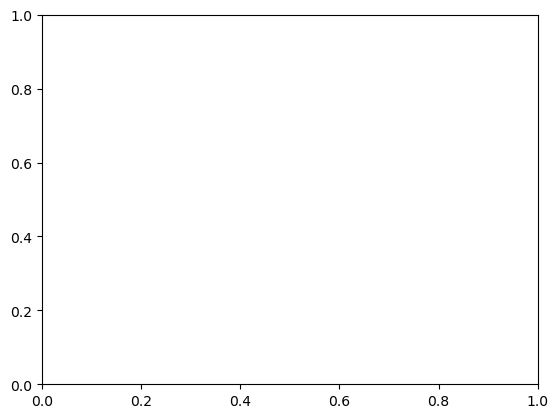

In [56]:
%matplotlib inline
print(beta.ravel().shape)
plt.plot(
    beta
)


In [59]:
i_beta

(array([2], dtype=int64),)

In [60]:
i_theta = np.where([k == 'theta' for k in env_fbands['008']['lfp_left']])[0][0]
i_beta = np.where([k == 'lo_beta' for k in env_fbands['008']['lfp_left']])[0][0]
i_cdrs = len(env_fbands['008']['lfp_left'])
i_time = i_cdrs + 1
i_task = i_time + 1

time_list, ratio_list = [], []

for sub, src in product(DATA.keys(),
                        ['lfp_left', 'lfp_right']):
    
    if sum(DATA[sub][src][i_cdrs, :]) == 0:
        print(f'sub {sub} had no LID')
        continue
    print(f'...calc {sub, src}')
    idx_sort = np.argsort(DATA[sub][src][i_time, :])
    sort_arr = DATA[sub][src][:, idx_sort]

    theta = sort_arr[i_theta, :]
    beta = sort_arr[i_beta, :]
    
    assert theta.shape == beta.shape, 'shapes unequal'

    i0_lid = np.where(sort_arr[i_cdrs, :] > 0)[0][0]
    t0_lid = sort_arr[i_time, i0_lid]
    lid_times = sort_arr[i_time, :] - t0_lid

    time_list.append(lid_times)
    ratio_list.append(theta / beta)


sub 017 had no LID
sub 017 had no LID
sub 109 had no LID
sub 109 had no LID
sub 101 had no LID
sub 101 had no LID


In [64]:
min_sec, max_sec = (
    int(np.min([np.min(l) for l in time_list])),
    int(np.max([np.max(l) for l in time_list]))
)

print(min_sec, max_sec)

-4305 4311


In [69]:
# create overall array per X seconds
WIN_LEN = 30
t_new = np.arange(min_sec, max_sec, WIN_LEN)

ratio_arr = np.array([[np.nan] * len(t_new)] * len(ratio_list))

for i_t, t0 in enumerate(t_new):

    for i_row, (sig_temp, t_temp) in enumerate(
        zip(ratio_list, time_list)
    ):
        # select idx for window
        win_sel = np.logical_and(t_temp > t0, t_temp < (t0 + WIN_LEN))
        # add mean ratio to correct idx
        ratio_arr[i_row, i_t] = np.mean(sig_temp[win_sel])
        

0 -4305


c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 -4275
2 -4245
3 -4215
4 -4185
5 -4155
6 -4125
7 -4095
8 -4065
9 -4035
10 -4005
11 -3975
12 -3945
13 -3915
14 -3885
15 -3855
16 -3825
17 -3795
18 -3765
19 -3735
20 -3705
21 -3675
22 -3645
23 -3615
24 -3585
25 -3555
26 -3525
27 -3495
28 -3465
29 -3435
30 -3405
31 -3375
32 -3345
33 -3315
34 -3285
35 -3255
36 -3225
37 -3195
38 -3165
39 -3135
40 -3105
41 -3075
42 -3045
43 -3015
44 -2985
45 -2955
46 -2925
47 -2895
48 -2865
49 -2835
50 -2805
51 -2775
52 -2745
53 -2715
54 -2685
55 -2655
56 -2625
57 -2595
58 -2565
59 -2535
60 -2505
61 -2475
62 -2445
63 -2415
64 -2385
65 -2355
66 -2325
67 -2295
68 -2265
69 -2235
70 -2205
71 -2175
72 -2145
73 -2115
74 -2085
75 -2055
76 -2025
77 -1995
78 -1965
79 -1935
80 -1905
81 -1875
82 -1845
83 -1815
84 -1785
85 -1755
86 -1725
87 -1695
88 -1665
89 -1635
90 -1605
91 -1575
92 -1545
93 -1515
94 -1485
95 -1455
96 -1425
97 -1395
98 -1365
99 -1335
100 -1305
101 -1275
102 -1245
103 -1215
104 -1185
105 -1155
106 -1125
107 -1095
108 -1065
109 -1035
110 -1005
111 -975

In [118]:
ratio_error = np.nanstd(ratio_arr, axis=0) / np.sqrt(ratio_arr.shape[0])
ratio_std = np.nanstd(ratio_arr, axis=0)
ratio_mean = np.nanmean(ratio_arr, axis=0)

# subjects contributing to mean, per window
n_subs_wins = np.sum(~np.isnan(ratio_arr), axis=0) / 2

c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\habetsj\AppData\Local\Temp\ipykernel_9684\2924042079.py:3: RuntimeWarning: Mean of empty slice
  ratio_mean = np.nanmean(ratio_arr, axis=0)


In [121]:
MIN_SUBS = 6
fsize = 14

fig, ax = plt.subplots(1,1, figsize=(8, 4))

ax.plot(t_new[n_subs_wins >= MIN_SUBS] / 60,
        ratio_mean[n_subs_wins >= MIN_SUBS])
ax.fill_between(t_new[n_subs_wins >= MIN_SUBS] / 60,
                y1=ratio_mean[n_subs_wins >= MIN_SUBS]-ratio_std[n_subs_wins >= MIN_SUBS],
                y2=ratio_mean[n_subs_wins >= MIN_SUBS]+ratio_std[n_subs_wins >= MIN_SUBS],
                alpha=.5,)
ax.axvline(x=0, color='gray', alpha=.5, lw=3,)
ax.axhline(y=1, color='gray', alpha=.5, lw=1,)
for y in [2, 3]: ax.axhline(y=y, color='gray',
                            alpha=.3, lw=.5,)

ax.set_ylabel('STN Theta / Beta Ratio\n(4-8 / 12-20 Hz)',
              size=fsize, weight='bold',)
ax.set_xlabel('Time vs Dyskinesia Onset (minutes)',
              size=fsize, weight='bold',)

ax.tick_params(axis='both', size=fsize, labelsize=fsize,)

ax.set_ylim(0.5, 4)

plt.tight_layout()

plt.savefig(os.path.join(utilsFiles.get_project_path('figures'),
                         'ft_exploration',
                         'data_v4.0_ft_v6',
                         f'theta_beta_ratio_v0_min{MIN_SUBS}subs'),
            dpi=300, facecolor='w',)

plt.close()

Extract Spectral Power and Variation in Feature windows

TODO:
- current gamma: only indiv peak, add sum gamma over 60 - 90

In [ ]:
def indiv_zscoring_feats(X_arr, sub_arr):

    for i_f, sub in product(np.arange(X_arr.shape[1]),
                            np.unique(sub_arr)):
        # loop over all feature and sub combinations
        sub_sel = sub_arr == sub
        m = np.mean(X_arr[sub_sel, i_f])
        sd = np.std(X_arr[sub_sel, i_f])
        # z-score values for sub
        X_arr[sub_sel, i_f] = (X_arr[sub_sel, i_f] - m) / sd
    
    return X_arr

In [ ]:
importlib.reload(ssdFeats)

X_arrs, y_arrs, sub_arrs = {}, {}, {}
mov_dep_code = {}

for i_mov, MOV_SEL in enumerate(['INDEP', 'DEPEND']):
    # loading/ creating/ saving in ssdFeats script
    (
        X_arrs[i_mov], y_arrs[i_mov], sub_arrs[i_mov], feat_names
    ) = ssdFeats.get_moveSpec_predArrays(
        MOV_SEL=MOV_SEL, LOAD_SOURCES=['STN',],
        POWER_METHOD='ENV'
    )
    # add movement code
    mov_dep_code[i_mov] = np.array([i_mov] * X_arrs[i_mov]['STN'].shape[0]).T

# merging for zscoring together
stn_X = np.concatenate([X_arrs[0]['STN'], X_arrs[1]['STN']], axis=0)
stn_y = np.concatenate([y_arrs[0]['STN'], y_arrs[1]['STN']], axis=0)
stn_subids = np.concatenate([sub_arrs[0]['STN'], sub_arrs[1]['STN']], axis=0)

mov_dep_code = np.concatenate([mov_dep_code[0], mov_dep_code[1]], axis=0)

In [ ]:
# calculate coefficients and pvalues
CDRS_categs = {0: 'none', 1: 'mild',
               2: 'moderate', 3: 'severe'}

X = stn_X.copy()
y = stn_y.copy()
sub_ids = stn_subids.copy()

stat_arr = {'INDEP': {'coef': [], 'pval': []},
            'DEPEND': {'coef': [], 'pval': []}}

X = indiv_zscoring_feats(X, sub_arr=sub_ids)

for i_ft, ft in enumerate(feat_names['STN']):
    

    for i_mov, MOV_SEL in enumerate(['INDEP', 'DEPEND']):
        mov_bool = mov_dep_code == i_mov
        # define X and groups for feat
        ft_temp = X[mov_bool, i_ft]
        y_temp = y[mov_bool]
        box_categs = [ft_temp[y_temp == cat]
                      for cat in CDRS_categs.keys()]
        # run LMM
        coeff, pval = lidStats.run_mixEff_wGroups(
            dep_var=ft_temp,
            indep_var=y_temp,
            groups=sub_ids[mov_bool],
            TO_ZSCORE=False,
        )
        # save in dict-lists
        stat_arr[MOV_SEL]['coef'].append(coeff)
        stat_arr[MOV_SEL]['pval'].append(pval)

        

In [ ]:
# plot boxplots per feature

FIG_NAME = '0129env_boxplots_specPowerVar_vs_LIDcategs'


fig, axes = plt.subplots(len(feat_names['STN']), 2,
                         figsize=(12, 18),
                         sharex='col', sharey='row')

for i_ft, ft in enumerate(feat_names['STN']):
    
    for i_mov, MOV_SEL in enumerate(['INDEP', 'DEPEND']):
        # get boxplot data
        mov_bool = mov_dep_code == i_mov
        # define X and groups for feat
        ft_temp = X[mov_bool, i_ft]
        y_temp = y[mov_bool]
        box_categs = [ft_temp[y_temp == cat]
                      for cat in CDRS_categs.keys()]
        
        # stats are calculated before

        # plotting
        coeff = stat_arr[MOV_SEL]['coef'][i_ft]
        pval = stat_arr[MOV_SEL]['pval'][i_ft]
        axes[i_ft, i_mov].boxplot(box_categs)
        if pval < (.05 / len(feat_names['STN'])): w = 'bold'
        else: w='normal'
        axes[i_ft, i_mov].set_title(f'{ft}, mov-{MOV_SEL}\n'
                f'(coeff {round(coeff, 2)}, '
                f'p={round(pval, 5)})',
                weight=w,)
        axes[i_ft, i_mov].set_ylim(-3, 3)

        axes[i_ft, i_mov].set_xticks([1,2,3,4])
        axes[i_ft, i_mov].set_xticklabels(CDRS_categs.values())
        axes[i_ft, i_mov].set_ylabel('indiv. z-scored feature\n(a.u.)')
        axes[i_ft, i_mov].set_xlabel('LID (CDRS sum)')

plt.tight_layout()

plt.savefig(os.path.join(utilsFiles.get_project_path('figures'),
                            'feat_dysk_corrs',
                            'corr_boxplots',
                            FIG_NAME),
            dpi=300, facecolor='w',)

plt.close()
        

In [ ]:
# plot HEATMAP

FIG_NAME = '0129cf_heatmap_specPowerVar_vs_LIDcategs'


fig, ax = plt.subplots(1, 1,
                         figsize=(12, 4),)
ALPHA = .05 / len(feat_names['STN'])
# 0 is not sign, 1 is sign
heat_arrs = {sig_label: np.array([
    [np.nan] * len(feat_names['STN'])
] * 2) for sig_label in [0, 1]}

for i_ft, ft in enumerate(feat_names['STN']):
    
    for i_mov, MOV_SEL in enumerate(['INDEP', 'DEPEND']):
        # fill arrays with stats calculated before
        coeff = stat_arr[MOV_SEL]['coef'][i_ft]
        pval = stat_arr[MOV_SEL]['pval'][i_ft]
        sig_lab = (pval < ALPHA).astype(int)
        heat_arrs[sig_lab][i_mov, i_ft] = coeff

# non-sign heatmap
vmin, vmax = -.25, .25
cmap = 'coolwarm'  # RdBu_r
nonsig_map = ax.imshow(heat_arrs[0], vmin=vmin, vmax=vmax,
                           cmap=cmap, )
# hatch = plt.pcolor(heat_arrs[0], vmin=vmin, vmax=vmax,
#                    hatch='//', cmap=cmap,
#                    edgecolor='w', )

# ax.imshow(X=heat_arrs[0], cmap='coolwarm',
        #   alpha=.6, vmin=-.3, vmax=.3,)
sig_map = ax.imshow(X=heat_arrs[1], cmap=cmap,  # RdBu_r
                    alpha=.9, vmin=vmin, vmax=vmax,)

for i_m, i_f in product(np.arange(heat_arrs[1].shape[0]),
                        np.arange(heat_arrs[1].shape[1])):
    if np.isnan(heat_arrs[1][i_m, i_f]): continue
    if abs(heat_arrs[1][i_m, i_f]) > .3: c='w'
    else: c = 'black'
    ax.text(i_f, i_m, s=round(heat_arrs[1][i_m, i_f], 2),
            color=c, horizontalalignment='center',
            verticalalignment='center', weight='bold',)

cbar = fig.colorbar(sig_map, pad=.01)
cbar.ax.set_ylabel('LMM coefficient (a.u.)')

ax.set_xticks(np.arange(len(feat_names['STN'])))
ax.set_xticklabels(feat_names['STN'],
                   rotation=75,)
ax.set_yticks([0, 1])
ax.set_yticklabels(['move-INDEPENDENT', 'move-DEPENDENT'],)

plt.tight_layout()

plt.savefig(os.path.join(utilsFiles.get_project_path('figures'),
                            'feat_dysk_corrs',
                            'corr_boxplots',
                            FIG_NAME),
            dpi=300, facecolor='w',)

plt.close()
        

In [ ]:
heat_arrs[1].shape